**Predicting Real Estate Prices in King County, WA 2014–2015**

##### Abstract

Real estate

##### Table of Contents

1) **Import Libraries and Read in Data**

2)  **EDA, Data Cleaning, and Feature Engineering**
<br>
2.1  What does the data look like?
<br>
2.2  Bedrooms and bathrooms
<br>
2.3  Square Footage
<br>
2.4  Floors, View, and Condition, Grade
<br>
2.5  Waterfront
<br>
2.6  Year Built
<br>
2.7  Year Renovated
<br>
2.8  Engineer feature for date in terms of years old (since built or renovated) at time of 
sale
<br>
2.9  Zipcode
<br>
2.10  Lat and Long
<br>
2.11  Add sqft per floor and cap outliers
<br>
2.12  Add dummy for basement
<br>
2.13  Add dummy for renovated
<br>
2.13  Drop date column

3)  **Modeling**
<br>
3.1  Set target to price
<br>
3.2  Drop price column
<br>
3.3  VIF
<br>
3.4  Baseline model (non-poly)
<br>
3.5  Generate Polynomial and Interaction features
<br>
3.6  Correlation matrix
<br>
3.7  Filter Methods
<br>
3.8  Wrapper Method

4)  **Pickle**

#### Import Libraries and Read in Data

In [1]:
# sklearn packages
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFECV

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle

# utility libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
df = pd.read_csv('kc_house_data_train.csv', index_col=0)

#### EDA, Data Cleaning, and Feature Engineering

##### What does the data look like?

In [3]:
# Examine the first couple rows
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283


In [4]:
# Examine datatypes
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

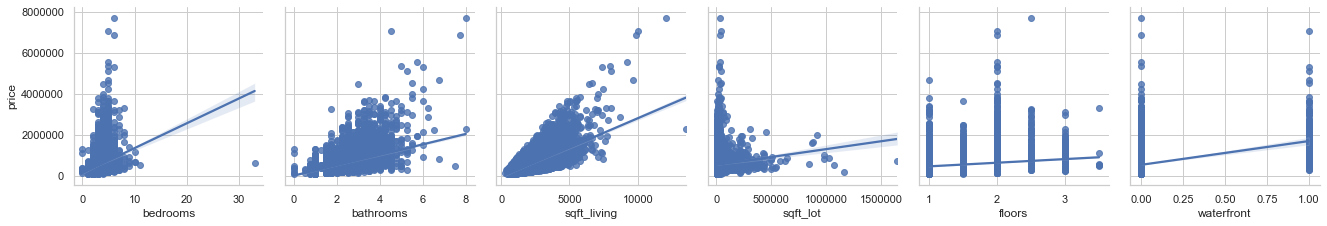

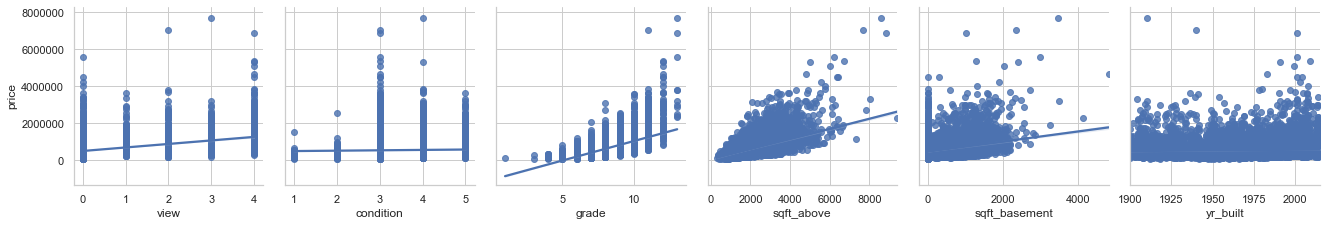

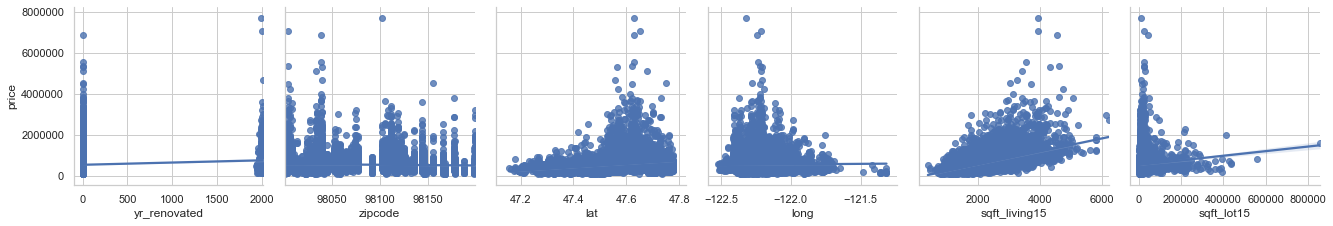

In [5]:
# Plot columns vs. price 4x4 plots
n = 6
row_groups = [df.columns[3:][i:i+n] for i in range(0, len(df.columns[3:]), n)]
for i in row_groups:
    pp = sns.pairplot(data=df[df.columns[2:]], y_vars='price',x_vars=i, kind="reg", height=3)

The data is all numeric except for time.

We will now examine each column more closely.

##### Bedrooms and bathrooms

In [6]:
# The house with 33 bedrooms (but only 1620 sqft_living) appears to be a typo
df.bedrooms.value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [7]:
df[df.bedrooms == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8597,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [8]:
# Fix 33 bdrms typo
df['bedrooms'] = df.bedrooms.replace([33],3)

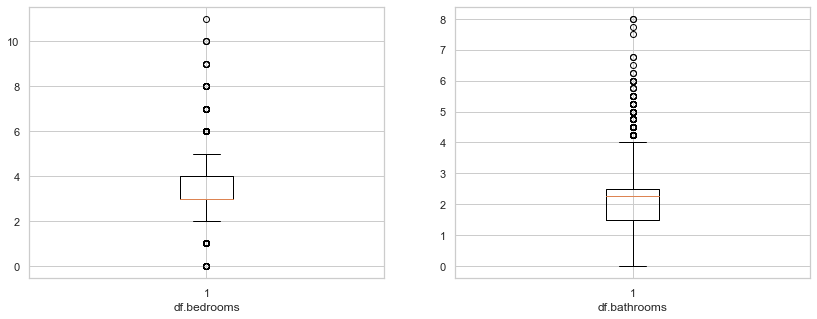

In [9]:
# Bedrooms and bathrooms appears to be normally distributed
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

ax[0].boxplot(df.bedrooms)
ax[0].set(xlabel='df.bedrooms')
ax[1].boxplot(df.bathrooms)
ax[1].set(xlabel='df.bathrooms')

plt.show()

##### Square Footage

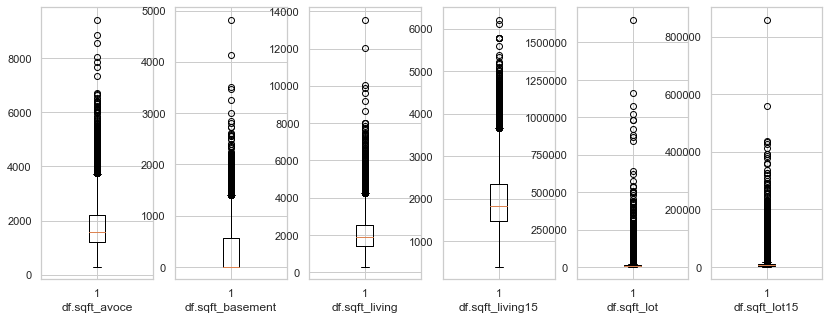

In [10]:
# There appear to be extreme outliers for all the columns pertaining to square footage.

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(14,5))

ax[0].boxplot(df.sqft_above)
ax[0].set(xlabel='df.sqft_avoce')
ax[1].boxplot(df.sqft_basement)
ax[1].set(xlabel='df.sqft_basement')
ax[2].boxplot(df.sqft_living)
ax[2].set(xlabel='df.sqft_living')
ax[3].boxplot(df.sqft_living15)
ax[3].set(xlabel='df.sqft_living15')
ax[4].boxplot(df.sqft_lot)
ax[4].set(xlabel='df.sqft_lot')
ax[5].boxplot(df.sqft_lot15)
ax[5].set(xlabel='df.sqft_lot15')

plt.show()

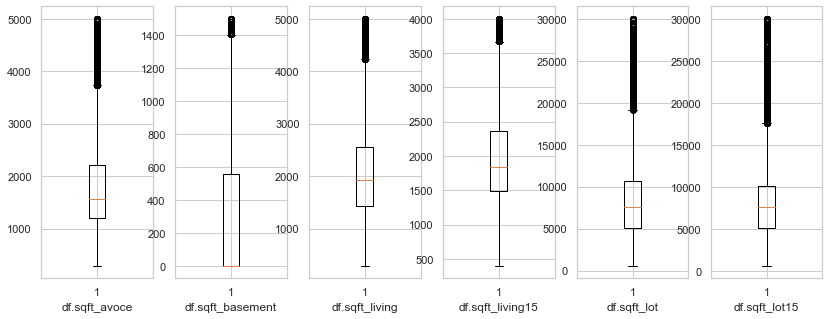

In [11]:
# We will cap these outliers in case they might skew our model

df['sqft_above'] = np.where(df['sqft_above'] > 5000, 5000, df['sqft_above'])
df['sqft_basement'] = np.where(df['sqft_basement'] > 1500, 1500, df['sqft_basement'])
df['sqft_living'] = np.where(df['sqft_living'] > 5000, 5000, df['sqft_living'])
df['sqft_living15'] = np.where(df['sqft_living15'] > 4000, 4000, df['sqft_living15'])
df['sqft_lot'] = np.where(df['sqft_lot'] > 30000, 30000, df['sqft_lot'])
df['sqft_lot15'] = np.where(df['sqft_lot15'] > 30000, 30000, df['sqft_lot15'])


fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(14,5))

ax[0].boxplot(df.sqft_above)
ax[0].set(xlabel='df.sqft_avoce')
ax[1].boxplot(df.sqft_basement)
ax[1].set(xlabel='df.sqft_basement')
ax[2].boxplot(df.sqft_living)
ax[2].set(xlabel='df.sqft_living')
ax[3].boxplot(df.sqft_living15)
ax[3].set(xlabel='df.sqft_living15')
ax[4].boxplot(df.sqft_lot)
ax[4].set(xlabel='df.sqft_lot')
ax[5].boxplot(df.sqft_lot15)
ax[5].set(xlabel='df.sqft_lot15')

plt.show()

##### Floors, View, and Condition, Grade

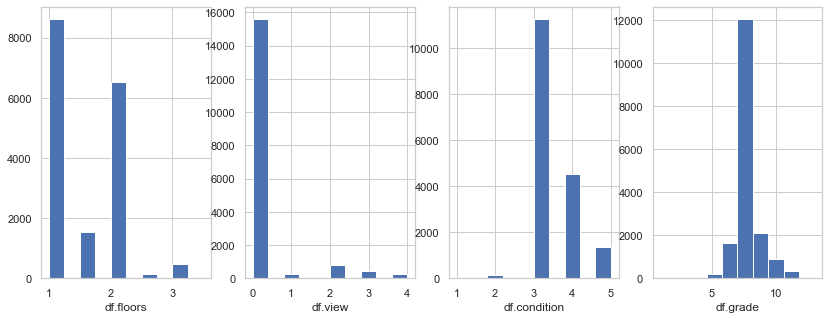

In [12]:
# These four features could potentially impact the price and might benefit from further exploration

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14,5))

ax[0].hist(df.floors)
ax[0].set(xlabel='df.floors')
ax[1].hist(df.view)
ax[1].set(xlabel='df.view')
ax[2].hist(df.condition)
ax[2].set(xlabel='df.condition')
ax[3].hist(df.grade)
ax[3].set(xlabel='df.grade')

plt.show()

##### Waterfront

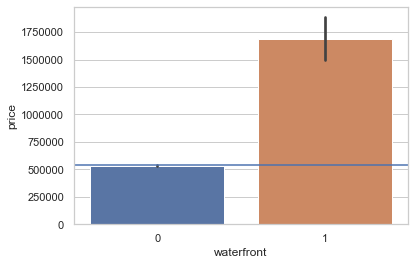

In [13]:
# Waterfront location has considerable impact on the price
x = df.waterfront
y = df.price
sns.barplot(x, y)
plt.axhline(df.price.mean())
plt.show()

##### Year Built

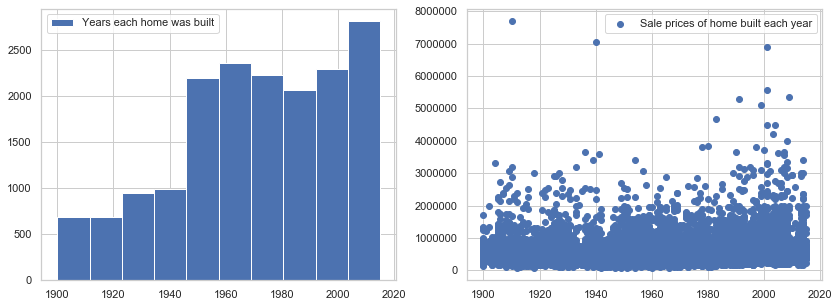

In [14]:
# Year built might be improved by interacting it with year renovated
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

ax[0].hist(df.yr_built)
ax[0].legend(['Years each home was built'])
ax[1].scatter(df.yr_built, df.price)
ax[1].legend(['Sale prices of home built each year'])
plt.show()

##### Year Renovated

With the number of houses not renovated, the year renovated feature appears almost like a dummy variable. Perhaps we could create a dummy variable and then interact year_renovated with year_built.

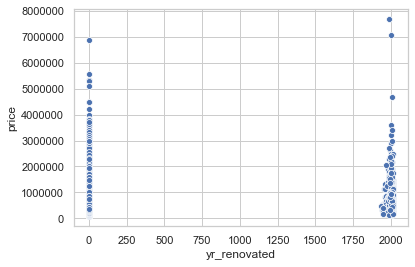

In [15]:
sns.scatterplot(df.yr_renovated, df.price)
plt.show()

##### Engineer feature for date in terms of years old (since built or renovated) at time of sale

Here we will first engineer a feature for the latter of year built or renovated. We will then engineer a second feature, years old, by subtracting the date built or renovated from the year sold. Next, we add a final age feature that expoentiates the years-old feature in order to better capture the relationship between years old and price. Lastly, we will drop off the yr_built_or_renovated and yrs_old features since they are likely to correlate highly with our age feature.

In [16]:
# Get latter of year built/renovated
df['yr_built_or_renovated'] = df.yr_built
df['yr_built_or_renovated'].where(df.yr_built > df.yr_renovated, df.yr_renovated, inplace=True)

# Subtract year built/renovated from date sold
df['years_old'] = df.date.map(lambda x : int(x[:4])) - df.yr_built_or_renovated # <--- caputring year by indexing str

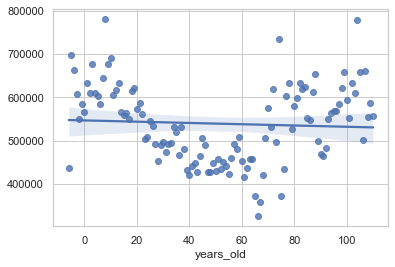

In [17]:
#non-linear relatioship btwn decade_built/reno and price
x = df.groupby('years_old').price.mean().index
y = df.groupby('years_old').price.mean().values

sns.regplot(x-5, y)

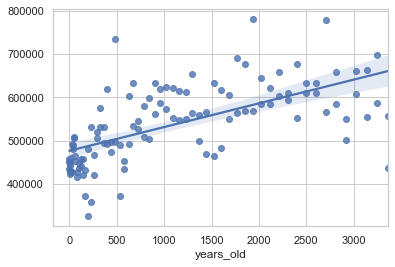

In [18]:
#non-linear relatioship btwn decade_built/reno and price
x = df.groupby('years_old').price.mean().index
y = df.groupby('years_old').price.mean().values

sns.regplot((x-57)**2, y)

In [19]:
# Add age_feature to df and drop yr_built_or_renovated and years_old
df['age_feature'] = (df['years_old']-57)**2

df.drop(columns=['yr_built_or_renovated', 'years_old'], inplace=True)

##### Zipcode`

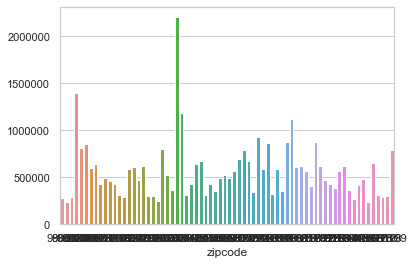

In [20]:
# We will convert zipcodes to dummy variables in order to best capture the catagorical effects.
x = df.groupby('zipcode').price.mean().index
y = df.groupby('zipcode').price.mean().values

sns.barplot((x), y)

In [21]:
# zipcode dummies
df = pd.get_dummies(df, columns=['zipcode'], drop_first=True)

##### Lat and Long`

We will not be performing geospatial analysis so it will be interesting to see what effect lat and long have, if any.

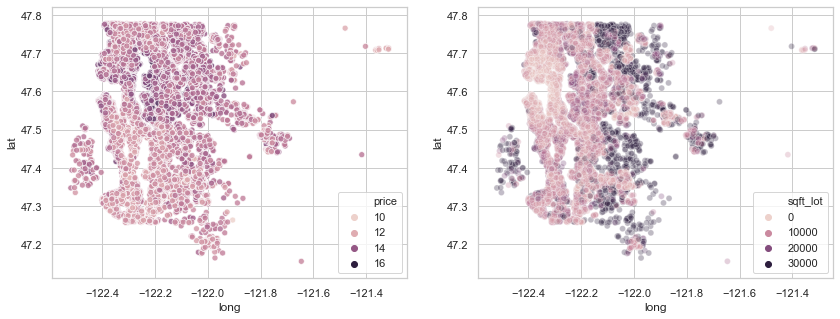

In [22]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.scatterplot(df.long, df.lat, hue=np.log(df.price), alpha=0.8, ax=ax[0])
sns.scatterplot(df.long, df.lat, hue=df.sqft_lot, alpha=0.3, ax=ax[1])
plt.show()

##### Add sqft per floor and cap outliers

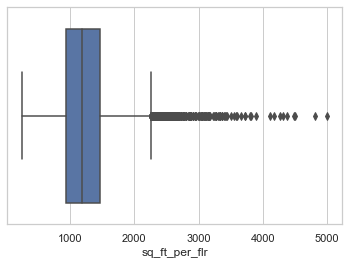

In [23]:
# Engineer feature for sqft per floor and remove outliers
df['sq_ft_per_flr'] = df.sqft_above / df.floors

sns.boxplot(df.sq_ft_per_flr)

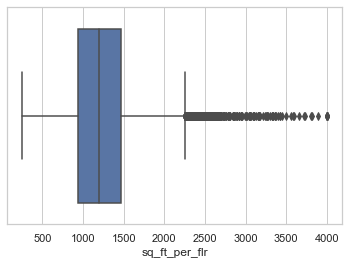

In [24]:
df['sq_ft_per_flr'] = np.where(df['sq_ft_per_flr'] > 4000, 4000, df['sq_ft_per_flr'])
sns.boxplot(df.sq_ft_per_flr)

##### Add dummy for basement

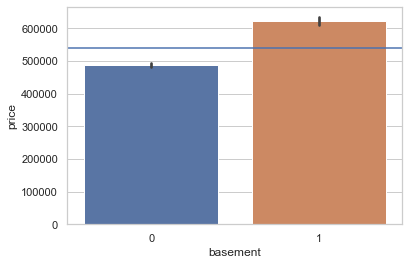

In [25]:
# Engineer a dummy feature for basement
df['basement'] = np.where(df.sqft_basement, 1, 0)

x = df.basement
y = df.price
sns.barplot(x, y)
plt.axhline(df.price.mean())
plt.show()

##### Add dummy for renovated

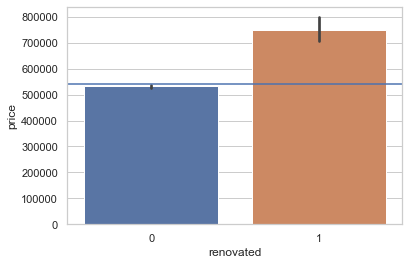

In [26]:
# Engineer a dummy feature for renovated
df['renovated'] = np.where(df.yr_renovated, 1, 0)

x = df.renovated
y = df.price
sns.barplot(x, y)
plt.axhline(df.price.mean())
plt.show()

##### Drop date column

In [27]:
# Drop date
df.drop(columns=['date'], inplace=True)

#### Modelling

##### Set target to price

In [28]:
# Set target
target = df['price']

##### Drop price column

In [29]:
# Drop target
df.drop(columns='price', inplace=True)

##### VIF

In [30]:
# Check variance inflation factor for highly correlated features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns

In [31]:
vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
13,16944.787227,yr_renovated
90,16928.878893,renovated
3,141.816258,sqft_living
10,118.161995,sqft_above
14,52.151123,lat
11,37.647280,sqft_basement
46,16.060410,zipcode_98052
40,15.199896,zipcode_98034
47,12.982718,zipcode_98053
80,12.364473,zipcode_98155


In [32]:
"""
Create a duplicate df to filter features by VIF. After modelling, VIF filters do now lower
RMSE
"""
df_vif = df[vif.sort_values(by='VIF Factor')[:-8].features.values]

In [33]:
df_vif.columns

Index(['zipcode_98148', 'waterfront', 'condition', 'zipcode_98032',
       'zipcode_98070', 'zipcode_98010', 'view', 'zipcode_98002',
       'zipcode_98022', 'zipcode_98188', 'zipcode_98003', 'bedrooms',
       'zipcode_98039', 'zipcode_98198', 'zipcode_98030', 'zipcode_98092',
       'zipcode_98166', 'zipcode_98031', 'age_feature', 'zipcode_98023',
       'zipcode_98102', 'zipcode_98109', 'zipcode_98168', 'zipcode_98055',
       'zipcode_98024', 'zipcode_98108', 'zipcode_98146', 'zipcode_98136',
       'zipcode_98178', 'yr_built', 'zipcode_98042', 'sqft_living15',
       'bathrooms', 'zipcode_98106', 'zipcode_98119', 'zipcode_98126',
       'zipcode_98007', 'id', 'grade', 'zipcode_98116', 'zipcode_98005',
       'basement', 'zipcode_98038', 'zipcode_98058', 'zipcode_98040',
       'zipcode_98105', 'zipcode_98056', 'zipcode_98144', 'zipcode_98122',
       'zipcode_98045', 'zipcode_98112', 'zipcode_98107', 'zipcode_98059',
       'zipcode_98199', 'zipcode_98014', 'zipcode_98004', 'zipco

##### Baseline model (non-poly)

In [34]:
# Train a baseline model before polynomial feature generation
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    df, target, random_state=34, test_size=0.2) # <---train test split

lm_baseline = linear_model.LinearRegression().fit(
    X_train_baseline, y_train_baseline) # <---linear regression model

train_rmse_baseline = np.sqrt(metrics.mean_squared_error(
    y_train_baseline, lm_baseline.predict(X_train_baseline))) # <---training RMSE

test_rmse_baseline = np.sqrt(metrics.mean_squared_error(
    y_test_baseline, lm_baseline.predict(X_test_baseline))) # <---test RMSE


In [35]:
print(list(zip(df.columns, lm_baseline.coef_))) #<---check coeffiecients

[('id', 8.808905713811644e-08), ('bedrooms', -18526.76092020504), ('bathrooms', 37054.172777064545), ('sqft_living', -532.8359421607815), ('sqft_lot', 3.449403194619805), ('floors', -113762.09703706678), ('waterfront', 641922.8935856656), ('view', 57670.159004083915), ('condition', 29621.622669958022), ('grade', 70148.67039029536), ('sqft_above', 742.4464180516661), ('sqft_basement', 666.9242802491062), ('yr_built', -688.204148600973), ('yr_renovated', 1605.8628492959251), ('lat', 290183.0515194024), ('long', -205639.15422199044), ('sqft_living15', 16.503333140004543), ('sqft_lot15', -1.19291736399191), ('age_feature', 14.318784738876275), ('zipcode_98002', 42298.82308684925), ('zipcode_98003', -26472.827466820996), ('zipcode_98004', 753841.3042211889), ('zipcode_98005', 225257.76907867144), ('zipcode_98006', 210585.65459478647), ('zipcode_98007', 188477.0919511068), ('zipcode_98008', 189656.5293956077), ('zipcode_98010', 111519.74383971706), ('zipcode_98011', 14054.964439418893), ('zi

In [36]:
# Our baseline train and test RMSE
display(f'Train RMSE Baseline: {train_rmse_baseline}, Test RMSE Baseline: {test_rmse_baseline}')

'Train RMSE Baseline: 163519.3839089476, Test RMSE Baseline: 169806.9631130061'

##### Generate Polynomial and Interaction features

In [37]:
# Generate 2nd degree polynomials and interactions for all non-dummy features
poly_features = ['condition', 'view', 'bedrooms', 'age_feature', 'yr_built',
                 'sqft_living15', 'bathrooms', 'basement', 'sqft_lot', 'sqft_lot15',
                 'sq_ft_per_flr', 'floors']

poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly_data_2 = poly_2.fit_transform(df[poly_features])
poly_columns_2 = poly_2.get_feature_names(poly_features)

df_poly_2 = pd.DataFrame(poly_data_2, columns=poly_columns_2)

In [38]:
X_train_poly_2, X_test_poly_2, y_train_poly_2, y_test_poly_2 = train_test_split(
    df_poly_2, target, random_state=34, test_size=0.2) # <---train test split

lm_poly_2 = linear_model.LinearRegression().fit(
    X_train_poly_2, y_train_poly_2) # <---linear regression model

train_rmse_poly_2 = np.sqrt(metrics.mean_squared_error(
    y_train_poly_2, lm_poly_2.predict(X_train_poly_2))) # <---training RMSE

test_rmse_poly_2 = np.sqrt(metrics.mean_squared_error(
    y_test_poly_2, lm_poly_2.predict(X_test_poly_2))) # <---test RMSE


In [39]:
print(list(zip(df_poly_2.columns, lm_poly_2.coef_))) #<---check coeffiecients

[('condition', 506526.704700851), ('view', -792717.2970630551), ('bedrooms', 628832.8456127753), ('age_feature', -1537.5012058407192), ('yr_built', 65197.33334933009), ('sqft_living15', 5922.665234667348), ('bathrooms', 487712.77200965624), ('basement', -699691.019730403), ('sqft_lot', 135.32898897034642), ('sqft_lot15', -528.544098938536), ('sq_ft_per_flr', 1379.194989808851), ('floors', -220210.61596087718), ('condition^2', -4852.211512010414), ('condition view', 5760.929489844198), ('condition bedrooms', -274.6660991387735), ('condition age_feature', -10.861349259176222), ('condition yr_built', -266.0293995121451), ('condition sqft_living15', 39.09460950876928), ('condition bathrooms', 6210.319661536551), ('condition basement', -946.5712296648524), ('condition sqft_lot', -1.7683128139806286), ('condition sqft_lot15', 1.3113615718857545), ('condition sq_ft_per_flr', -8.159342142748983), ('condition floors', 16337.31143285908), ('view^2', 32564.540449115884), ('view bedrooms', -19113.

In [57]:
# The 2nd degree polynomial performs worse initially but may improve with refinement
display(f'Train RMSE poly^2: {train_rmse_poly_2}, Test RMSE poly^2: {test_rmse_poly_2}')

'Train RMSE poly^2: 211367.74058088873, Test RMSE poly^2: 215756.02061069207'

In [41]:
# Generate 2nd degree polynomials and interactions for all non-dummy features
poly_features = ['condition', 'view', 'bedrooms', 'age_feature', 'yr_built',
                 'sqft_living15', 'bathrooms', 'basement', 'sqft_lot', 'sqft_lot15',
                 'sq_ft_per_flr', 'floors']

poly_3 = PolynomialFeatures(degree=3, include_bias=False)
poly_data_3 = poly_3.fit_transform(df[poly_features])
poly_columns_3 = poly_3.get_feature_names(poly_features)

df_poly_3 = pd.DataFrame(poly_data_3, columns=poly_columns_3)

In [42]:
X_train_poly_3, X_test_poly_3, y_train_poly_3, y_test_poly_3 = train_test_split(
    df_poly_3, target, random_state=34, test_size=0.2) # <---train test split

lm_poly_3 = linear_model.LinearRegression().fit(
    X_train_poly_3, y_train_poly_3) # <---linear regression model

train_rmse_poly_3 = np.sqrt(metrics.mean_squared_error(
    y_train_poly_3, lm_poly_3.predict(X_train_poly_3))) # <---training RMSE

test_rmse_poly_3 = np.sqrt(metrics.mean_squared_error(
    y_test_poly_3, lm_poly_3.predict(X_test_poly_3))) # <---test RMSE


In [43]:
print(list(zip(df_poly_3.columns, lm_poly_3.coef_))) #<---check coeffiecients

[('condition', 2.7571406140038612), ('view', -5845.26350013116), ('bedrooms', -14098.206438462032), ('age_feature', 53117.475312144765), ('yr_built', -20420.69021155061), ('sqft_living15', -70810.34970702155), ('bathrooms', 3499.8666680695105), ('basement', -402.9538305310345), ('sqft_lot', 15178.531594190086), ('sqft_lot15', 986.1965753700058), ('sq_ft_per_flr', -100077.52825235314), ('floors', -13255.672701815965), ('condition^2', 24706.55890088664), ('condition view', -455561.85483809916), ('condition bedrooms', -596111.6680559549), ('condition age_feature', -804.0927154248035), ('condition yr_built', 509.9353431265646), ('condition sqft_living15', -1044.6031059960642), ('condition bathrooms', -359995.28562945727), ('condition basement', 68183.25432205586), ('condition sqft_lot', 47.71635926670958), ('condition sqft_lot15', 39.07310533423762), ('condition sq_ft_per_flr', 1733.5764205558646), ('condition floors', -169535.8882402078), ('view^2', -800879.6960039046), ('view bedrooms', 

In [58]:
# The 3rd degree polynomial also performs worse initially but may improve with refinement
display(f'Train RMSE poly^3: {train_rmse_poly_3}, Test RMSE poly^3: {test_rmse_poly_3}')

'Train RMSE poly^3: 238352.14299956014, Test RMSE poly^3: 261602.46550228674'

##### Correlation matrix

In [45]:
# Check correlations for features of baseline df
corr_matrix = X_train_baseline.corr().abs() # <---create correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # <---select upper triangle of correlation matrix
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)] # <---find index of feature columns with correlation greater than 0.90

In [47]:
to_drop

['sqft_lot15', 'renovated']

In [48]:
# Drop features with a correlation > .9
# (dropping yr_renovated instead of the renovated feature we engineered)
X_train_baseline_drop_corr = X_train_baseline.drop(columns=['yr_renovated', 'sqft_lot15'])
X_test_baseline_drop_corr = X_test_baseline.drop(columns=['yr_renovated', 'sqft_lot15'])

##### Filter Methods

In [49]:
"""
Compare how each feature of our baseline df performs relative to the target by
conducting independent f-tests using K_best

"""
selector = SelectKBest(f_regression, k=50) # <--- F-Test (filter method; before fitting model)
selector.fit(X_train_baseline, y_train_baseline)
selected_columns = X_train_baseline.columns[selector.get_support()]
# removed_columns = X_train_baseline.columns[~selector.get_support()] # <---uncomment to view removed columns

X_train_baseline_k_best = X_train_baseline[selected_columns]
X_test_baseline_k_best = X_test_baseline[selected_columns]

lm_baseline_k_best = linear_model.LinearRegression().fit(
    X_train_baseline_k_best, y_train_baseline) # <---linear regression model

train_rmse_baseline_k_best = np.sqrt(metrics.mean_squared_error(
    y_train_baseline, lm_baseline_k_best.predict(X_train_baseline_k_best))) # <---training RMSE

test_rmse_baseline_k_best = np.sqrt(metrics.mean_squared_error(
    y_test_baseline, lm_baseline_k_best.predict(X_test_baseline_k_best))) # <---test RMSE

In [59]:
# The baseline K_best performs almost as well on the test as it does on the train data
display(f'Train RMSE baseline K_best: {train_rmse_baseline_k_best}, Test RMSE baseline K_best: {test_rmse_baseline_k_best}')

'Train RMSE baseline K_best: 172738.71622129733, Test RMSE baseline K_best: 179620.06571043166'

In [53]:
# Run K_best again on our 2nd deg. polynomial df
selector = SelectKBest(f_regression, k=50) # <--- F-Test (filter method; before fitting model)
selector.fit(X_train_poly_2, y_train_poly_2)
selected_columns = X_train_poly_2.columns[selector.get_support()]
# removed_columns = X_train_poly_2.columns[~selector.get_support()] # <---uncomment to view removed columns

X_train_poly_2_k_best = X_train_poly_2[selected_columns]
X_test_poly_2_k_best = X_test_poly_2[selected_columns]

lm_poly_2_k_best = linear_model.LinearRegression().fit(
    X_train_poly_2_k_best, y_train_poly_2) # <---linear regression model

train_rmse_poly_2_k_best = np.sqrt(metrics.mean_squared_error(
    y_train_poly_2, lm_poly_2_k_best.predict(X_train_poly_2_k_best))) # <---training RMSE

test_rmse_poly_2_k_best = np.sqrt(metrics.mean_squared_error(
    y_test_poly_2, lm_poly_2_k_best.predict(X_test_poly_2_k_best))) # <---test RMSE

In [60]:
# Again 2nd degree polynomial scores poorly
display(f'Train RMSE poly^2 K_best: {train_rmse_poly_2_k_best}, Test RMSE poly^2 K_best: {test_rmse_poly_2_k_best}')

'Train RMSE baseline K_best: 216585.02161887908, Test RMSE baseline K_best: 218574.56585052446'

In [55]:
# Run K_best on our 3rd deg. polynomial df
selector = SelectKBest(f_regression, k=50) # <--- F-Test (filter method; before fitting model)
selector.fit(X_train_poly_3, y_train_poly_3)
selected_columns = X_train_poly_3.columns[selector.get_support()]
# removed_columns = X_train_poly_3.columns[~selector.get_support()]

X_train_poly_3_k_best = X_train_poly_3[selected_columns]
X_test_poly_3_k_best = X_test_poly_3[selected_columns]

lm_poly_3_k_best = linear_model.LinearRegression().fit(
    X_train_poly_3_k_best, y_train_poly_3) # <---linear regression model

train_rmse_poly_3_k_best = np.sqrt(metrics.mean_squared_error(
    y_train_poly_3, lm_poly_3_k_best.predict(X_train_poly_3_k_best))) # <---training RMSE

test_rmse_poly_3_k_best = np.sqrt(metrics.mean_squared_error(
    y_test_poly_3, lm_poly_3_k_best.predict(X_test_poly_3_k_best))) # <---test RMSE



In [56]:
# The 3rd degree also scores poorly
display(f'Train RMSE poly^3 K_best: {train_rmse_poly_3_k_best}, Test RMSE poly^3 K_best: {test_rmse_poly_3_k_best}')

(227938.35672877321, 236580.9102542513)

##### Wrapper Methods

In [61]:
"""
Examine features in the context of the whole model, checking if accounting for
interactions/variation in other features would make any features more important than
just an f-test would indicate.

Cross validation breaks training set into smaller train/test sets and takes the average to
hedge against variance.

"""

ols = linear_model.LinearRegression() # <---create recursive feature eliminator
selector = RFECV(estimator=ols,
                 step=1,
                 cv=5,
                 scoring='neg_mean_squared_error',
                 n_jobs=-1) # <---score features by mean squared errors (increase step size to make faster)
selector.fit(X_train_baseline, y_train_baseline) #<---fit recursive feature eliminator     
selected_columns = X_train_baseline.columns[selector.support_]
# removed_columns = X_train_baseline.columns[~selector.support_]

X_train_baseline_rfe = X_train_baseline[selected_columns]
X_test_baseline_rfe = X_test_baseline[selected_columns]

lm_baseline_rfe = linear_model.LinearRegression().fit(
    X_train_baseline[selected_columns], y_train_baseline) # <---linear regression model

train_baseline_rfe_rmse = np.sqrt(metrics.mean_squared_error(
    y_train_baseline, lm_baseline_rfe.predict(X_train_baseline[selected_columns]))) # <---training RMSE

test_baseline_rfe_rmse = np.sqrt(metrics.mean_squared_error(
    y_test_baseline, lm_baseline_rfe.predict(X_test_baseline[selected_columns]))) # <---test RMSE

In [65]:
# dffefe
display(f'Train RMSE baseline RFE: {train_baseline_rfe_rmse}, Test RMSE baseline RFE: {test_baseline_rfe_rmse}')

'Train RMSE baseline RFE: 163519.5624641132, Test RMSE baseline RFE: 169799.2779611743'

In [63]:
ols = linear_model.LinearRegression() # <---create recursive feature eliminator
selector = RFECV(estimator=ols,
                 step=1,
                 cv=5,
                 scoring='neg_mean_squared_error',
                 n_jobs=-1) # <---score features by mean squared errors (increase step size to make faster)
selector.fit(X_train_poly_2, y_train_poly_2) #<---fit recursive feature eliminator     
selected_columns = X_train_poly_2.columns[selector.support_]
# removed_columns = X_train_poly_2.columns[~selector.support_]

X_train_poly_2_rfe = X_train_poly_2[selected_columns]
X_test_poly_2_rfe = X_test_poly_2[selected_columns]

lm_poly_2_rfe = linear_model.LinearRegression().fit(
    X_train_poly_2_rfe, y_train_poly_2) # <---linear regression model

train_poly_2_rfe_rmse = np.sqrt(metrics.mean_squared_error(
    y_train_poly_2, lm_poly_2_rfe.predict(X_train_poly_2_rfe))) # <---training RMSE

test_poly_2_rfe_rmse = np.sqrt(metrics.mean_squared_error(
    y_test_poly_2, lm_poly_2_rfe.predict(X_test_poly_2_rfe))) # <---test RMSE

In [66]:
# reree
display(f'Train RMSE poly^2 RFE: {train_poly_2_rfe_rmse}, Test RMSE poly^2 RFE: {test_poly_2_rfe_rmse}')

'Train RMSE poly^2 RFE: 211370.62093238198, Test RMSE poly^2 RFE: 215777.86799441194'

In [64]:
ols = linear_model.LinearRegression() # <---create recursive feature eliminator
selector = RFECV(estimator=ols,
                 step=1,
                 cv=5,
                 scoring='neg_mean_squared_error',
                 n_jobs=-1) # <---score features by mean squared errors (increase step size to make faster)
selector.fit(X_train_poly_3, y_train_poly_3) #<---fit recursive feature eliminator     
selected_columns = X_train_poly_3.columns[selector.support_]
# removed_columns = X_train_poly_3.columns[~selector.support_]

X_train_poly_3_rfe = X_train_poly_3[selected_columns]
X_test_poly_3_rfe = X_test_poly_3[selected_columns]

lm_poly_3_rfe = linear_model.LinearRegression().fit(
    X_train_poly_3_rfe, y_train_poly_3) # <---linear regression model

train_poly_3_rfe_rmse = np.sqrt(metrics.mean_squared_error(
    y_train_poly_3, lm_poly_3_rfe.predict(X_train_poly_3_rfe))) # <---training RMSE

test_poly_3_rfe_rmse = np.sqrt(metrics.mean_squared_error(
    y_test_poly_3, lm_poly_3_rfe.predict(X_test_poly_3_rfe))) # <---test RMSE

In [67]:
# dffd
display(f'Train RMSE poly^3 RFE: {train_poly_3_rfe_rmse}, Test RMSE poly^3 RFE: {test_poly_3_rfe_rmse}')

'Train RMSE poly^3 RFE: 193379.49102448695, Test RMSE poly^3 RFE: 214341.66641423348'

##### Final Model

In [68]:
display(f'Train RMSE Baseline: {train_rmse_baseline}, Test RMSE Baseline: {test_rmse_baseline}')

display(f'Train RMSE poly^2: {train_rmse_poly_2}, Test RMSE poly^2: {test_rmse_poly_2}')
display(f'Train RMSE poly^3: {train_rmse_poly_3}, Test RMSE poly^3: {test_rmse_poly_3}')

display(f'Train RMSE baseline K_best: {train_rmse_baseline_k_best}, Test RMSE baseline K_best: {test_rmse_baseline_k_best}')
display(f'Train RMSE poly^2 K_best: {train_rmse_poly_2_k_best}, Test RMSE poly^2 K_best: {test_rmse_poly_2_k_best}')
display(f'Train RMSE poly^3 K_best: {train_rmse_poly_3_k_best}, Test RMSE poly^3 K_best: {test_rmse_poly_3_k_best}')

display(f'Train RMSE baseline RFE: {train_baseline_rfe_rmse}, Test RMSE baseline RFE: {test_baseline_rfe_rmse}')
display(f'Train RMSE poly^2 RFE: {train_poly_2_rfe_rmse}, Test RMSE poly^2 RFE: {test_poly_2_rfe_rmse}')
display(f'Train RMSE poly^3 RFE: {train_poly_3_rfe_rmse}, Test RMSE poly^3 RFE: {test_poly_3_rfe_rmse}')

'Train RMSE Baseline: 163519.3839089476, Test RMSE Baseline: 169806.9631130061'

'Train RMSE poly^2: 211367.74058088873, Test RMSE poly^2: 215756.02061069207'

'Train RMSE poly^3: 238352.14299956014, Test RMSE poly^3: 261602.46550228674'

'Train RMSE baseline K_best: 172738.71622129733, Test RMSE baseline K_best: 179620.06571043166'

'Train RMSE poly^2 K_best: 216585.02161887908, Test RMSE poly^2 K_best: 218574.56585052446'

'Train RMSE poly^3 K_best: 227938.35672877321, Test RMSE poly^3 K_best: 236580.9102542513'

'Train RMSE baseline RFE: 163519.5624641132, Test RMSE baseline RFE: 169799.2779611743'

'Train RMSE poly^2 RFE: 211370.62093238198, Test RMSE poly^2 RFE: 215777.86799441194'

'Train RMSE poly^3 RFE: 193379.49102448695, Test RMSE poly^3 RFE: 214341.66641423348'

In [71]:
X_train_baseline_rfe.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'age_feature', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zipcode_98077', 'zipcode_9809

In [ ]:
"""

"""


"""can you tell from the test rmse and train rmse that your model is not overfitting?
(test rmse is good relative to train rmse)


investigate what the selected columns are before passing to holdout"""

#### Pickle

In [73]:
ols = linear_model.LinearRegression() # <---create recursive feature eliminator
selector = RFECV(estimator=ols,
                 step=1,
                 cv=5,
                 scoring='neg_mean_squared_error',
                 n_jobs=-1) # <---score features by mean squared errors (increase step size to make faster)
selector.fit(df, target) #<---fit recursive feature eliminator     
selected_columns = df.columns[selector.support_]

lm_final = linear_model.LinearRegression().fit(
    df[selected_columns], target) # <---linear regression model
lm_final.coef_

array([-1.85272558e+04,  3.93537534e+04, -5.65112997e+02,  3.30340393e+00,
       -1.09604453e+05,  6.63166801e+05,  5.92957894e+04,  2.99615636e+04,
        6.89620093e+04,  7.68251403e+02,  6.96078022e+02, -6.63870361e+02,
        1.84472994e+03,  2.97620386e+05, -1.95399022e+05,  1.87766809e+01,
       -8.30383970e-01,  1.40807528e+01,  4.49793591e+04, -2.12742278e+04,
        7.34512250e+05,  2.34874916e+05,  2.13835951e+05,  1.86656626e+05,
        1.93455195e+05,  1.05714362e+05,  1.38906789e+04,  8.14310835e+04,
        1.29419015e+04,  6.64461827e+04, -4.74339846e+04,  1.54849302e+05,
        1.53585025e+05,  3.11253326e+03,  1.81216621e+05, -2.28415479e+02,
       -1.75163883e+02, -2.51453612e+03,  2.66448303e+05,  1.00280444e+05,
        5.78338649e+04,  1.23826247e+06,  4.39168562e+05,  1.83417755e+04,
        1.36459568e+05,  1.48158512e+05,  1.26997963e+05,  1.99806699e+04,
        5.78540102e+04,  1.84758817e+04,  5.57042004e+04,  9.72780923e+04,
       -9.49413627e+04,  

In [76]:
print(f"Final RMSE: {np.sqrt(metrics.mean_squared_error(target, lm_final.predict(df[selected_columns])))}")

Final RMSE: 164589.36380846368


In [78]:
pickle_out = open("model/model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()